In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.optim
from torch.autograd import Variable
from copy import deepcopy


In [2]:
resModel = torchvision.models.resnet18()

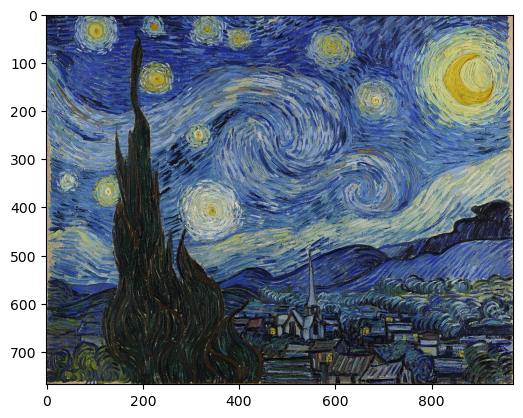

In [3]:
# img = Image.open("C:/Users/Paxton/workspace/styleTransfer/invert/grace_hopper.jpg")
img = Image.open("C:/Users/Paxton/Pictures/starryNight.jpg")
plt.imshow(img)

size = [224, 224]
mu = [0.485, 0.456, 0.406]
sigma = [0.229, 0.224, 0.225]

class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class Clip(object):
    def __init__(self):
        return

    def __call__(self, tensor):
        t = tensor.clone()
        t[t>1] = 1
        t[t<0] = 0
        return t

transform = transforms.Compose([
        transforms.Resize(size=size),
        transforms.CenterCrop(size=size),
        transforms.ToTensor(),
        # transforms.Normalize(mu, sigma),
    ])

detransform = transforms.Compose([
        # Denormalize(mu, sigma),
        Clip(),
        transforms.ToPILImage(),
    ])

In [4]:
transform(img).unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

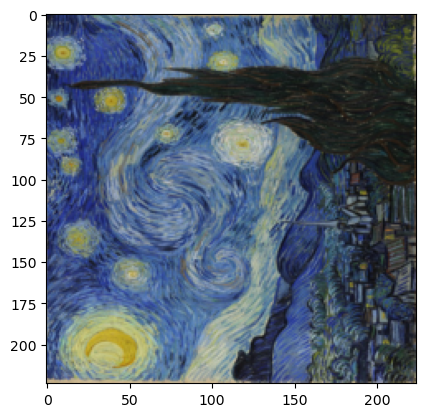

In [5]:
plt.imshow(transform(img).detach().numpy().T)

In [6]:
resModel(transform(img).unsqueeze(0)).shape

torch.Size([1, 1000])

In [7]:
resModel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

: 

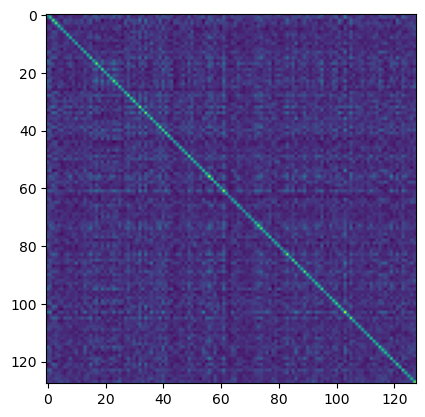

In [30]:

activation = {}
layer = 'layer2'

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook


resModel.layer2.register_forward_hook(get_activation(layer))

styleInputTarget = deepcopy(transform(img).unsqueeze(0))
styleOutput = resModel(styleInputTarget)

targetActivations = activation[layer].detach()

targetActivations.shape

F = targetActivations.view(128,28*28)

targetGramMat = F @ F.T

# plt.imshow(targetGramMat.numpy())


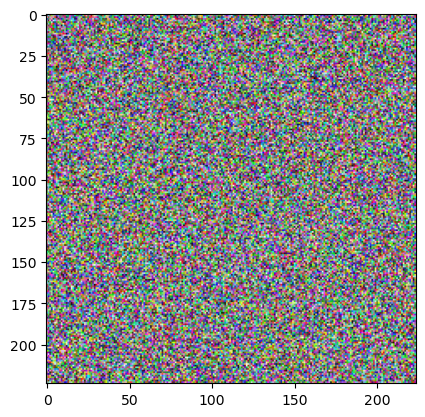

Epoch 1:Loss: 118522360.000000
Epoch 2:Loss: 113268832.000000
Epoch 3:Loss: 69162928.000000
Epoch 4:Loss: 57341132.000000
Epoch 5:Loss: 49670880.000000
Epoch 6:Loss: 44015200.000000
Epoch 7:Loss: 39641244.000000
Epoch 8:Loss: 36185452.000000
Epoch 9:Loss: 33377084.000000
Epoch 10:Loss: 31050440.000000
Epoch 11:Loss: 29069920.000000
Epoch 12:Loss: 27351744.000000
Epoch 13:Loss: 25841196.000000
Epoch 14:Loss: 24498458.000000
Epoch 15:Loss: 23289888.000000
Epoch 16:Loss: 22194328.000000
Epoch 17:Loss: 21203256.000000
Epoch 18:Loss: 20297724.000000
Epoch 19:Loss: 19468914.000000
Epoch 20:Loss: 18708816.000000
Epoch 21:Loss: 18007088.000000
Epoch 22:Loss: 17357100.000000
Epoch 23:Loss: 16750806.000000
Epoch 24:Loss: 16178701.000000
Epoch 25:Loss: 15638868.000000
Epoch 26:Loss: 15127494.000000
Epoch 27:Loss: 14644996.000000
Epoch 28:Loss: 14188244.000000
Epoch 29:Loss: 13757146.000000
Epoch 30:Loss: 13350658.000000
Epoch 31:Loss: 12962862.000000
Epoch 32:Loss: 12592570.000000
Epoch 33:Loss: 

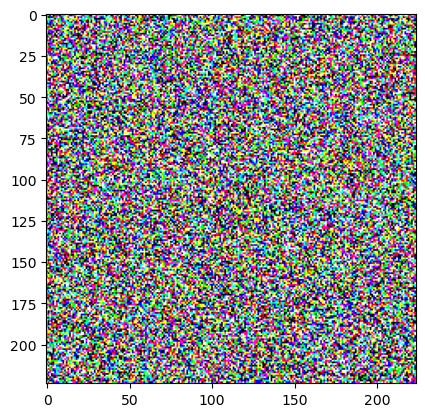

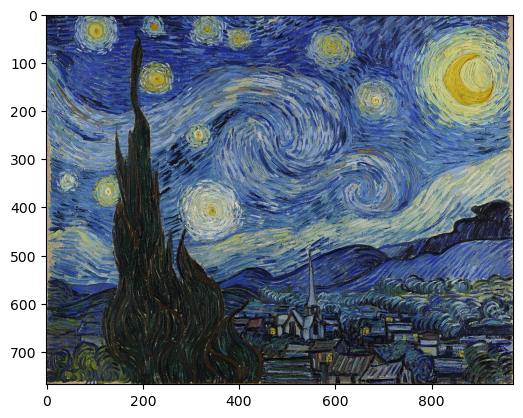

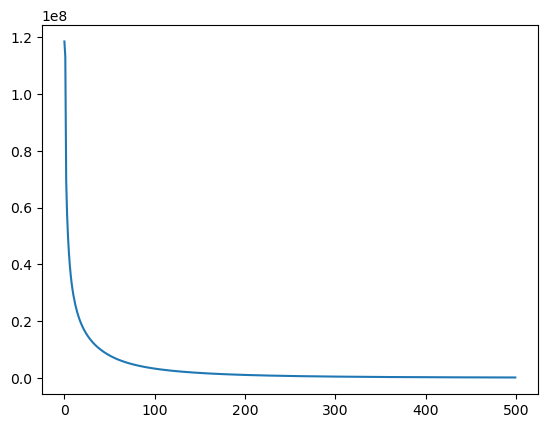

In [34]:
# def computeMSE(xActivations, targetActivations):
#     return torch.div(alpha_prior(xActivations - targetActivations, alpha=2.), alpha_prior(targetActivations, alpha=2.))

# def tvReg(x_, beta):
#     # assert(x_.size(0) == 1)
#     xImg = x_[0]
#     dy = xImg - xImg # set size of derivative and set border = 0
#     dx = xImg - xImg
#     dy[:,1:,:] = -xImg[:,:-1,:] + xImg[:,1:,:]
#     dx[:,:,1:] = -xImg[:,:,:-1] + xImg[:,:,1:]
#     return ((dx.pow(2) + dy.pow(2)).pow(beta/2.)).sum()

# def computeLoss(x_, acts, targetActs, p, lam_p, beta, lam_tv):
#     return computeMSE(acts, targetActs) + lam_p*alpha_prior(x_, p) + lam_tv*tvReg(x_, beta)
#     # return computeMSE(acts, targetActs) + lam_p*pNormReg(x_, p) + lam_tv*tvReg(x_, beta)

def alpha_prior(x_, alpha=2.):
    return torch.abs(x_.view(-1)**alpha).sum()

# alpha = 6
# lam_p = 1e-6
# # lam_p = 0
# beta = 2.
# lam_tv = 5e-6
# # lam_tv = 0
numEpochs = 500

x = Variable(torch.rand(size=(1, 3, size[0], size[1])), requires_grad=True)
optimizer = torch.optim.Adam([x], lr=1e1)

plt.imshow(x.detach().numpy()[0].T)
plt.show()

losses = []
print_iter = 1
loss_counter = 0
for epochInd in range(numEpochs):
    _ = resModel(x)
    xActivations = activation[layer]
    xF = xActivations.view(128,28*28)
    xGramMat = xF @ xF.T

    loss = alpha_prior(xGramMat - targetGramMat, 2)

    if (epochInd+1) % print_iter == 0:
        print('Epoch %d:Loss: %f' % (epochInd+1, loss.data.cpu().numpy()))

    losses = losses + [loss.detach().item()]

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()


    # actLoss = computeMSE(xActivations, targetActivations)
    # normLoss = alpha_prior(x, alpha)
    # tvLoss = tvReg(x, beta)

    # loss = actLoss + lam_p*normLoss + lam_tv*tvLoss
    # loss = 

    # if (epochInd+1) % print_iter == 0:
    #         print('Epoch %d:\tNorm Loss: %f\tTV Loss: %f\tLoss: %f\tTot Loss: %f' % (epochInd+1,
    #             normLoss.data.cpu().numpy(), tvLoss.data.cpu().numpy(),
    #             actLoss.data.cpu().numpy(), loss.data.cpu().numpy()))

    # losses = losses + [loss.detach().item()]

    # optimizer.zero_grad()
    # loss.backward(retain_graph=True)
    # optimizer.step()

    # if len(losses) > 20 and loss_counter > 10:
    #     if (np.mean(losses[-20:-10]) / np.mean(losses[-10:]) - 1) < .01:
    #         print("Loss decremented")
    #         loss_counter = 0
    #         for g in optimizer.param_groups:
    #             g['lr'] = g['lr'] / 2
    # else:
    #     loss_counter = loss_counter + 1
    

plt.imshow(detransform(x.detach()[0]))
plt.show()

plt.imshow(img)
plt.show()

plt.plot(losses)
plt.show()



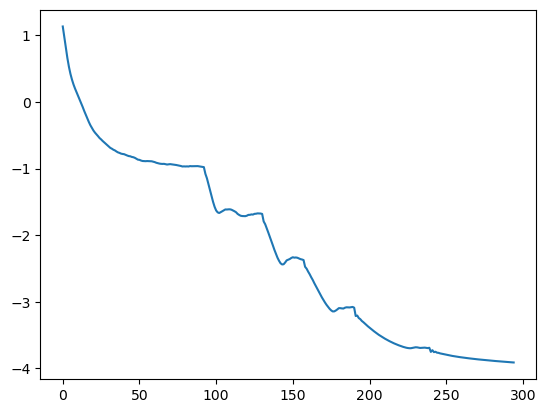

[1.6895720958709717,
 2.7485527992248535,
 3.5852417945861816,
 3.78393816947937,
 3.5464863777160645,
 3.1126246452331543,
 2.6520183086395264,
 2.253979444503784,
 1.9393998384475708,
 1.7013071775436401,
 1.5279382467269897,
 1.4017491340637207,
 1.3029017448425293,
 1.2246527671813965,
 1.1587764024734497,
 1.0976566076278687,
 1.0398342609405518,
 0.9824349880218506,
 0.9282554388046265,
 0.8740273714065552,
 0.8275499939918518,
 0.7816325426101685,
 0.7411634922027588,
 0.7060127258300781,
 0.6774817705154419,
 0.6519815325737,
 0.6317389607429504,
 0.6156267523765564,
 0.5990716814994812,
 0.582324743270874,
 0.5706087946891785,
 0.5572737455368042,
 0.5459567308425903,
 0.533951997756958,
 0.5237200260162354,
 0.5140852332115173,
 0.5023547410964966,
 0.49631166458129883,
 0.4885995388031006,
 0.4835696816444397,
 0.4758259952068329,
 0.4695332646369934,
 0.46583181619644165,
 0.46080365777015686,
 0.4584159851074219,
 0.45693254470825195,
 0.4522661566734314,
 0.44803595542907

In [127]:
# x.shape
# x
plt.plot(np.log(losses[5:]))
plt.show()

losses


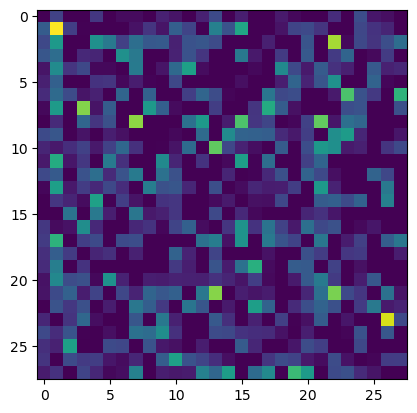

In [23]:
plt.imshow(activation['layer2'][0,0,:,:].detach().numpy())